In [1]:
# study how changing deltaR and nRechits parameter of the algorithm changes the signal efficiency

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

lumi = {'MC_Summer16':35.9*1000,
        'MC_Fall17': 41.5*1000, 
        'MC_Fall18':  59.7*1000 ,
       
       }

years = ['MC_Summer16', 'MC_Fall17', 'MC_Fall18']
scan_points = False
masses = ['15','40','55']
ctaus = ['100','1000','10000','100000']
ctaus = ['100000']
ntupler_version = 'V1p17/'

comparison = ['0p2','0p3']
analyzer_version = ["/v1/v38/", "/v1/v40/"]

comparison = ['0p2','0p1']
analyzer_version = ["/v1/v38/", "/v1/v39/"]
scan_deltaR = True
data = False
#0 is signal only, 1 is data, 2 is both
if scan_deltaR:
#     comparison = ['0p1','0p2', '0p3']
#     analyzer_version = ["/v1/v39/", "/v1/v38/", "/v1/v40/"]
    if data == 0:
        comparison = ['0p1','0p2', '0p3','1']
        analyzer_version = ["/v1/v46/", "/v1/v43/", "/v1/v47/","/v1/v45/"]
    elif data == 1:
        comparison = ['0p1','0p2', '0p3']
        analyzer_version = ["/v5/v46/", "/v5/v48/","/v5/v47/"]
    else:
        print("ERROR")
        
        
        
else:
    comparison = ['50','30']
    analyzer_version = ["/v1/v38/", "/v1/v41/"]

if data:
    for i in range(len(comparison)):
        data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version[i]+'/normalized/'
        fpath[comparison[i]] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root' 
else:
    for i in range(len(comparison)):
        for y in years:
            mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/'+y+'/'+analyzer_version[i]+'/normalized/'
            if scan_points:
                for m in masses:
                    for ct in ctaus:
                        if '16' in y:fpath[y+'_mx'+m+'ctau'+ct+'_'+comparison[i]] = mc_path + 'ggH_HToSSTobbbb_MH-125_MS-'+m+'_ctau-'+ct+'_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
                        else: fpath[y+'_mx'+m+'ctau'+ct+'_'+comparison[i]] = mc_path + 'ggH_HToSSTobbbb_MH-125_MS-'+m+'_ctau-'+ct+'_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
            else:
                fpath[y+'_'+comparison[i]] = mc_path + 'ggH_HToSSTobbbb_MH-125.root'


NEvents = {}
for k,v in fpath.items():
    print (k, v)
   
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    print(len(a))



MC_Summer16_0p1 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Summer16//v1/v46//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 24199240.0
15228
MC_Fall17_0p1 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall17//v1/v46//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 510598660.0
14148
MC_Fall18_0p1 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18//v1/v46//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 780197800.0
20759
MC_Summer16_0p2 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Summer16//v1/v43//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 24199240.0
1387516
MC_Fall17_0p2 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall17//v1/v43//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 510598660.0
1373725
MC_Fall18_0p2 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJet

# Number of clusters with 30/50

In [4]:
%%time
weight_denom = {}
nCsc = {}
deltaR = {}
EtaSpread = {}
PhiSpread = {}
if scan_points:
    for m in masses:
        for ct in ctaus:
            for i in comparison:
                weight_denom['mx'+m+'ctau'+ct+'_'+i] = []
                nCsc['mx'+m+'ctau'+ct+'_'+i] = []
                deltaR['mx'+m+'ctau'+ct+'_'+i] = []
else:
    for i in comparison:
        weight_denom[i] = []
        nCsc[i] = []
        deltaR[i] = []
        EtaSpread[i] = []
        PhiSpread[i] = []

for k,T in tree.items():
    if not data:
        split_list = k.split("_")
        year = split_list[0]+"_"+split_list[1]
        clusterSize = split_list[-1]
    else:
        clusterSize = k
    if scan_points:
        mct = split_list[2]
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
    ########### SELECTION: EVENTS ############
#     sel_ev   = T.array('METTrigger')
    HLTDecision = T.array('HLTDecision')
    sel_ev = np.logical_or(T.array('HLTDecision')[:,310], T.array('HLTDecision')[:,467])
    if not '16' in k: sel_ev = sel_ev|HLTDecision[:,703] | HLTDecision[:,717] | HLTDecision[:,710] | HLTDecision[:,709]
    

    sel_ev = np.logical_and(sel_ev ,T.array('met') > 200)
    sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
    sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    if not data: sel_ev = np.logical_and(sel_ev ,np.sum(T.array('gLLP_csc'),axis = 1) >= 1)

    cluster_index = '3'
    ########### SELECTION: CLUSTERS ############

    
    if data:
#         sel_rechitcluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, \
#                                        T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0)
        sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < -12.5

    else:
        sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
        
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)



#     r_denom[clusterSize] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten())
#     z_denom[clusterSize] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten())
    if scan_points:weight_denom[mct+'_'+clusterSize] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight'))[sel_ev]*lumi[year])
    else:
        if data: weight_denom[clusterSize] += [1]* np.count_nonzero(sel_ev)
        else: weight_denom[clusterSize] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight'))[sel_ev]*lumi[year])
        nCsc[clusterSize] += list(T.array('cscRechitCluster'+cluster_index+'Size')[sel_rechitcluster][sel_ev][:,0])
        deltaR[clusterSize] += list(T.array('cscRechitCluster'+cluster_index+'DeltaRSpread')[sel_rechitcluster][sel_ev][:,0])
        EtaSpread[clusterSize] += list(T.array('cscRechitCluster'+cluster_index+'EtaSpread')[sel_rechitcluster][sel_ev][:,0])
        PhiSpread[clusterSize] += list(T.array('cscRechitCluster'+cluster_index+'PhiSpread')[sel_rechitcluster][sel_ev][:,0])





        
if scan_points:
    for m in masses:
        for ct in ctaus:
            k = 'mx'+m+'ctau'+ct
            print(k, 'improvement: ', np.sum(weight_denom[k+'_'+comparison[1]])/np.sum(weight_denom[k+'_'+comparison[0]]))
else:
    print('improvement:', np.sum(weight_denom[comparison[1]])/np.sum(weight_denom[comparison[0]]))
    
    

improvement: 1.0343919
CPU times: user 2min 27s, sys: 15.4 s, total: 2min 43s
Wall time: 2min 40s


In [22]:
np.arange(50,130,10)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120])

# Plots

0p1 0.2 0.9544446
0p2 0.2 0.9248365
0p3 0.2 0.89389133


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


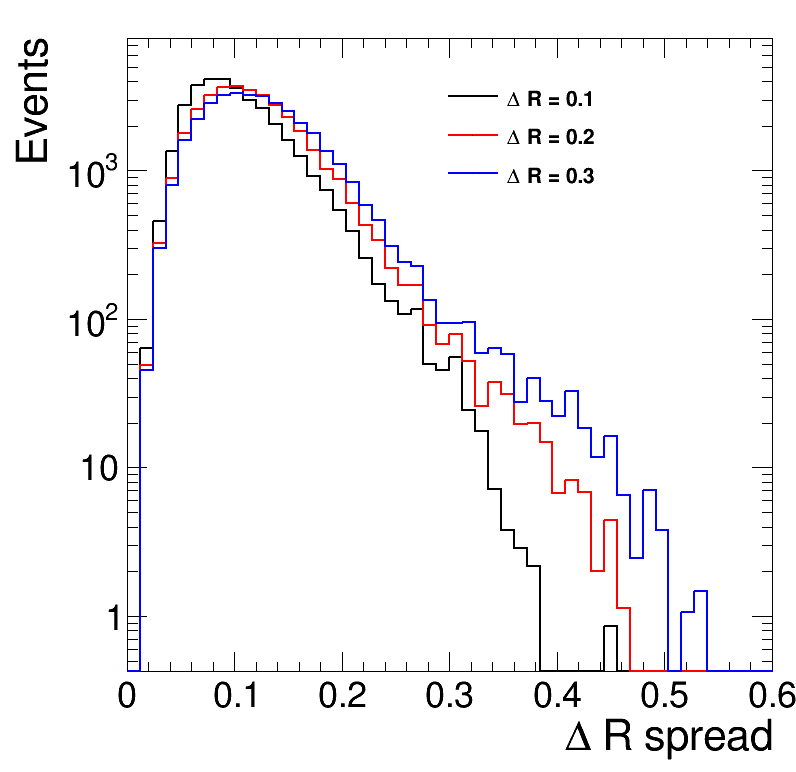

In [5]:

leg = rt.TLegend(0.55,0.75,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}

var = [nCsc, deltaR, EtaSpread, PhiSpread]
name = ['nCsc', 'deltaR', 'EtaSpread', 'PhiSpread']
xaxis = ['N_{rechits}', '#Delta R spread', '#eta spread', '#phi spread']
bins = [[50,0,3000], [50,0,0.6], [50,0,0.5], [50,0,0.5]]
j = 1
for i,k in enumerate(nCsc.keys()):
    if i == len(nCsc.keys())-1:continue
    h[k] = create_TH1D(var[j][k],  axis_title=[xaxis[j], 'Events'], binning = bins[j],weights = weight_denom[k])
    
    print(k, 0.2, np.sum(np.array(weight_denom[k])[np.array(deltaR[k])<0.2])/np.sum(np.array(weight_denom[k])))

#     print(weight_denom[k])
#     print(k, 130, np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=130]))
#     print(k, 115, np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=115])/np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=130]))


#     for nrechit in np.arange(110,130,1):
#         if np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=nrechit])>np.sum(np.array(weight_denom['0p2'])[np.array(nCsc['0p2'])>=130]):
#             print(nrechit, np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=nrechit]))


#     if scan_deltaR:print(k, np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=130])/np.sum(np.array(weight_denom['0p2'])[np.array(nCsc['0p2'])>=130]), \
#           np.sum(np.array(weight_denom[k]))/np.sum(np.array(weight_denom['0p2'])))
#     else:print(k, np.sum(np.array(weight_denom[k])[np.array(nCsc[k])>=130])/np.sum(np.array(weight_denom['50'])[np.array(nCsc['50'])>=130]), \
#           np.sum(np.array(weight_denom[k]))/np.sum(np.array(weight_denom['50'])))
    h[k].SetLineColor(std_color_list[i])
#     h[k].SetMaximum(1000000)
    h[k].Draw('same hist')
#     leg.AddEntry(h[k],'Rechit threshold = ' +k)
    if scan_deltaR:
        leg.AddEntry(h[k],'#Delta R = ' +k.replace("p", "."))
    else:
        leg.AddEntry(h[k],'N_{rechits} threshold = ' +k.replace("p", "."))


c.SetRightMargin(0.03)
# c.SetLogx()
c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
# if scan_deltaR:
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/clustering_scanDeltaR'+name[j]+'.png')
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/clustering_scanDeltaR'+name[j]+'.png')
# else:
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/clustering_scanNrechits'+name[j]+'.png')
#     c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/clustering_scanNrechits'+name[j]+'.png')

